Lo que hemos visto en la sección anterior, es una forma más manual de hacer la normalización.

A continuación, condensaremos el conocimiento anterior.


In [72]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

torch.manual_seed(3)

transform = transforms.ToTensor()

train_full = datasets.CIFAR10("./data", train=True, download=True, transform=transform)


#Obtenemos el dataset train completo
loader_train = DataLoader(train_full, batch_size=len(train_full), shuffle=False)                       
#Obtenemos un batch de datos
imgs, _ = next(iter(loader_train))             
imgs = imgs.to(torch.float64)
print(imgs.shape) # [50000,3,32,32]

CIFAR10_MEAN = imgs.mean(dim=(0,2,3))
CIFAR10_STD  = imgs.std(dim=(0,2,3))
print(CIFAR10_MEAN, CIFAR10_STD)


cuda
torch.Size([50000, 3, 32, 32])
tensor([0.4914, 0.4822, 0.4465], dtype=torch.float64) tensor([0.2470, 0.2435, 0.2616], dtype=torch.float64)


In [73]:

#CIFAR10_MEAN = torch.tensor([0.4914, 0.4822, 0.4465])
#CIFAR10_STD  = torch.tensor([0.2470, 0.2435, 0.2616])

#Creamos el transform para normalización

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN.tolist(), CIFAR10_STD.tolist())
])

# Re-creamos los datasets con el nuevo transform
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)


#Comprobamos que los datos estan normalizados
check_loader_train_full = DataLoader(train_full, batch_size=len(train_full), shuffle=False) #Dataset completo para calcular la media y la desviación estándar de los datos ya normalizados
x, _ = next(iter(check_loader_train_full))
mean_check = x.mean(dim=(0, 2, 3))
std_check  = x.std(dim=(0, 2, 3))
print("Mean Appx: 0):", mean_check)
print("Std Appx: 1):", std_check)
assert mean_check.abs().max() < 0.05
assert (std_check - 1).abs().max() < 0.05



#Dividimos el dataset en train y validation
train_set, val_set = torch.utils.data.random_split(generator=torch.Generator().manual_seed(3), dataset=train_full, lengths=[40000, 10000])
#Comprobamos que el dataset se ha dividido correctamente
print(len(train_set), len(val_set))

#Nuestros loaders para entrenar, validar y testear, ya normalizados.
loader_train = DataLoader(train_set, batch_size=128, shuffle=True) #Barajamos porque es train y mejora la generalización
loader_val = DataLoader(val_set, batch_size=256, shuffle=False)
loader_test = DataLoader(test_set, batch_size=256, shuffle=False)








Mean Appx: 0): tensor([ 6.3542e-08, -1.9292e-08, -4.8446e-08])
Std Appx: 1): tensor([1.0000, 1.0000, 1.0000])
40000 10000


Vamos ahora a coger el primer batch

In [74]:
images, labels = next(iter(loader_train))
print(images.shape, labels.shape)

torch.Size([128, 3, 32, 32]) torch.Size([128])


# Declaración de arquitectura

In [75]:

import torch.nn as nn

def get_flatten_size(model_features, input_shape=(1, 3, 32, 32)):
    with torch.no_grad():
        x = torch.zeros(input_shape)
        out = model_features(x)
        return out.view(out.size(0), -1).size(1)

class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.features = nn.Sequential(

            #Primera capa de convolucion, entra una imagen de 3 canales y sale una imagen de 32 features
            #El kernel es de 3x3 y el padding es 1 (same padding)
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), #Aplicamos pooling max para reducir la dimensionalidad de la imagen

            #Segunda capa de convolucion, entra una imagen de 16 features y sale una imagen de 32 features
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), #Aplicamos pooling max para reducir la dimensionalidad de la imagen

            #Tercera capa de convolucion, entra una imagen de 32 features y sale una imagen de 64 features
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.MaxPool2d(kernel_size=2, stride=2), #Aplicamos pooling max para reducir la dimensionalidad de la imagen

             nn.Dropout(p=0.3), #Aplicamos dropout para evitar el overfitting
        )

        n_flat = get_flatten_size(self.features)

        

        #Añadimos una capa lineal para clasificar
        self.classifier = nn.Sequential(
            nn.Flatten(), #Aplanamos la imagen para que sea un vector
          
            
            nn.Linear(in_features=n_flat, out_features=500), #Una capa lineal con n_flat entradas y 500 salidas
            nn.ReLU(), #Aplicamos la funcion de activacion ReLU
            nn.Dropout(p=0.4), #Aplicamos dropout para evitar el overfitting
            
            nn.Linear(in_features=500, out_features=10), #Una capa lineal con 500 entradas y 10 salidas
            # No aplicamos softmax, ya que la funcion de perdida que usamos (CrossEntropyLoss) lo aplica por defecto
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x





# Instancia
model = CIFAR10CNN()
print(model)

x = torch.randn(4, 3, 32, 32)
logits = model(x)
print(logits.shape)



CIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)
torch.Size([4, 10])


In [76]:
from torchsummary import summary

summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
          Dropout-10             [-1, 64, 4, 4]               0
          Flatten-11                 [-1, 1024]               0
           Linear-12                  [-1, 500]         512,500
             ReLU-13                  [-1, 500]               0
          Dropout-14                  [

### Vamos a declarar el bucle de entramiento

Vamos a recordar los parametros tipicos de SDG

| Parámetro  | Rol                                                      | Valor típico |
| ---------- | -------------------------------------------------------- | ------------ |
| `lr`       | tamaño del paso (cuánto cambian los pesos por gradiente) | 0.01–0.1     |
| `momentum` | cuánto “recuerda” del gradiente anterior                 | 0.8–0.95     |


In [77]:
EPOCHS = 30  # número de pasadas por el dataset
lr = 0.01
momentum = 0.9
#Definimos la funcion de perdida y el optimizador
criterion = nn.CrossEntropyLoss()

#lr es la tasa de aprendizaje, momentum es el factor de inercia, es decir, cuanto se mueve el optimizador en la direccion del gradiente y 
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)


model.to(device)  # mueve el modelo a GPU
model.train()     # pone el modelo en modo entrenamiento (activa dropout, etc.)



CIFAR10CNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=500, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [78]:
for epoch in range(1, EPOCHS+1):
    total, correct = 0, 0
    running_loss = 0.0
    print(f"[inicio] epoch {epoch}")


[inicio] epoch 1
[inicio] epoch 2
[inicio] epoch 3
[inicio] epoch 4
[inicio] epoch 5
[inicio] epoch 6
[inicio] epoch 7
[inicio] epoch 8
[inicio] epoch 9
[inicio] epoch 10
[inicio] epoch 11
[inicio] epoch 12
[inicio] epoch 13
[inicio] epoch 14
[inicio] epoch 15
[inicio] epoch 16
[inicio] epoch 17
[inicio] epoch 18
[inicio] epoch 19
[inicio] epoch 20
[inicio] epoch 21
[inicio] epoch 22
[inicio] epoch 23
[inicio] epoch 24
[inicio] epoch 25
[inicio] epoch 26
[inicio] epoch 27
[inicio] epoch 28
[inicio] epoch 29
[inicio] epoch 30


In [79]:
def evaluate(model, loader, device, criterion):
    model.eval()
    total, correct, total_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            loss = criterion(logits, labels)
            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

#Vamos a guardar los resultados de las epocas para poder hacer graficas
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in loader_train:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    test_loss, test_acc = evaluate(model, loader_test, device, criterion)

    #Vamos a guardar los resultados de las epocas para poder hacer graficas
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(
        f"Época {epoch}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
        f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}"
    )


Época 1/30 | Train Loss: 1.9549 | Train Acc: 0.2777 | Test Loss: 1.5440 | Test Acc: 0.4320
Época 2/30 | Train Loss: 1.4871 | Train Acc: 0.4555 | Test Loss: 1.3531 | Test Acc: 0.5165
Época 3/30 | Train Loss: 1.2968 | Train Acc: 0.5316 | Test Loss: 1.1595 | Test Acc: 0.5876
Época 4/30 | Train Loss: 1.1743 | Train Acc: 0.5808 | Test Loss: 1.0284 | Test Acc: 0.6420
Época 5/30 | Train Loss: 1.0781 | Train Acc: 0.6178 | Test Loss: 0.9634 | Test Acc: 0.6642
Época 6/30 | Train Loss: 0.9917 | Train Acc: 0.6511 | Test Loss: 0.9281 | Test Acc: 0.6777
Época 7/30 | Train Loss: 0.9344 | Train Acc: 0.6725 | Test Loss: 0.8954 | Test Acc: 0.6903
Época 8/30 | Train Loss: 0.8912 | Train Acc: 0.6856 | Test Loss: 0.8287 | Test Acc: 0.7178
Época 9/30 | Train Loss: 0.8473 | Train Acc: 0.7032 | Test Loss: 0.8153 | Test Acc: 0.7189
Época 10/30 | Train Loss: 0.8012 | Train Acc: 0.7174 | Test Loss: 0.7971 | Test Acc: 0.7270
Época 11/30 | Train Loss: 0.7657 | Train Acc: 0.7309 | Test Loss: 0.7915 | Test Acc: 0.73

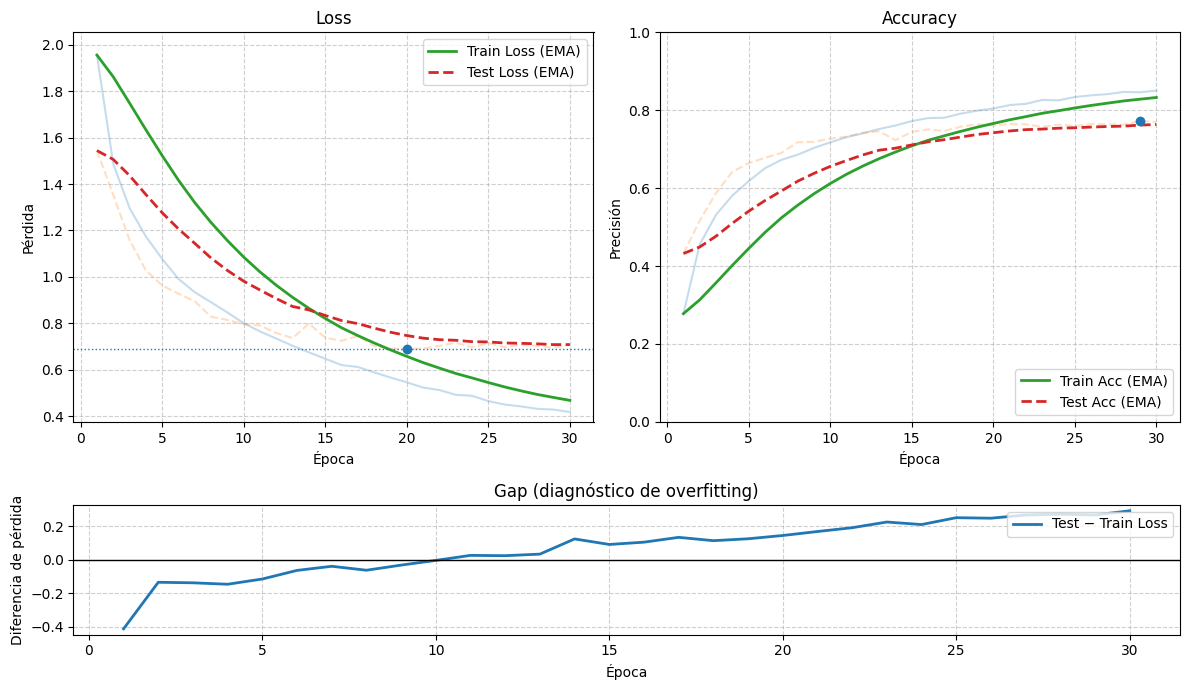

In [80]:
#SHOW PLOTS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def ema(x, alpha=0.2):
    y = np.array(x, dtype=float).copy()
    for i in range(1, len(y)):
        y[i] = alpha*y[i] + (1-alpha)*y[i-1]
    return y

epochs = np.arange(1, len(train_losses)+1)
trL, teL = np.array(train_losses), np.array(test_losses)
trA, teA = np.array(train_accuracies), np.array(test_accuracies)

trL_s, teL_s = ema(trL, 0.2), ema(teL, 0.2)
trA_s, teA_s = ema(trA, 0.2), ema(teA, 0.2)

best_idx = int(np.argmin(teL))
gap = teL - trL

fig = plt.figure(figsize=(12,7))
gs = GridSpec(2, 2, height_ratios=[3,1], figure=fig)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(epochs, trL, alpha=0.25)
ax1.plot(epochs, teL, alpha=0.25, linestyle='--')
ax1.plot(epochs, trL_s, linewidth=2, label='Train Loss (EMA)')
ax1.plot(epochs, teL_s, linewidth=2, linestyle='--', label='Test Loss (EMA)')
ax1.scatter(epochs[best_idx], teL[best_idx], zorder=3)
ax1.axhline(teL[best_idx], linestyle=':', linewidth=1)
ymin = min(trL.min(), teL.min())*0.9
ymax = max(trL.max(), teL.max())*1.05
ax1.set_ylim(ymin, ymax)
ax1.set_xlabel('Época'); ax1.set_ylabel('Pérdida'); ax1.set_title('Loss')
ax1.grid(True, linestyle='--', alpha=0.6); ax1.legend(loc='upper right')

ax2 = fig.add_subplot(gs[0,1])
ax2.plot(epochs, trA, alpha=0.25)
ax2.plot(epochs, teA, alpha=0.25, linestyle='--')
ax2.plot(epochs, trA_s, linewidth=2, label='Train Acc (EMA)')
ax2.plot(epochs, teA_s, linewidth=2, linestyle='--', label='Test Acc (EMA)')
ax2.scatter(epochs[np.argmax(teA)], teA.max(), zorder=3)
ax2.set_ylim(0, 1.0)
ax2.set_xlabel('Época'); ax2.set_ylabel('Precisión'); ax2.set_title('Accuracy')
ax2.grid(True, linestyle='--', alpha=0.6); ax2.legend(loc='lower right')

ax3 = fig.add_subplot(gs[1, :])
ax3.plot(epochs, gap, linewidth=2, label='Test − Train Loss')
ax3.axhline(0.0, color='k', linewidth=1)
ax3.set_xlabel('Época'); ax3.set_ylabel('Diferencia de pérdida'); ax3.set_title('Gap (diagnóstico de overfitting)')
ax3.grid(True, linestyle='--', alpha=0.6); ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()
